based off of https://github.com/scverse/scvi-tutorials/blob/main/scrna/scVI_DE_worm.ipynb

# Differential expression on C. elegans data

This notebook was contributed by Eduardo Beltrame [@Munfred](https://github.com/Munfred) and edited by Romain Lopez, Adam Gayoso, and Pierre Boyeau.

Processing and visualizing 89k cells from Packer et al. 2019 C. elegans 10xv2 single cell data

Original article:
`A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution`

https://science.sciencemag.org/content/365/6459/eaax1971.long

The anndata object we provide  has 89,701 cells and 20,222 genes.
It includes short gene descriptions from [WormBase](https://wormbase.org) that will show up when mousing over the interactive plots.

**Steps performed**:

1. Loading the data from anndata containing cell labels and gene descriptions
1. Training the model with batch labels for integration with scVI
1. Retrieving the scVI latent space and imputed values
1. Visualize the latent space with an interactive t-SNE plot using Plotly
1. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
import os
import tempfile
import torch.functional as F
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
import seaborn as sns
import torch
import scvi

# set pandas display options
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)

/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_gene_likelihood(adata):
    """
    Determines the appropriate gene likelihood distribution for the SCVI model 
    based on the properties of the input AnnData object.
    
    Parameters:
    - adata: AnnData object containing single-cell RNA-seq data.

    Returns:
    - str: Selected gene likelihood distribution ("nb", "zinb", "poisson").
    """
    
    # Check for zero-inflation by counting the proportion of zero values in the data
    zero_proportion = (adata.X == 0).sum() / adata.X.size
    
    # Select likelihood based on zero inflation and count properties
    if zero_proportion > 0.4:
        gene_likelihood = "zinb"  # Zero-Inflated Negative Binomial for high zero-inflation
    elif adata.X.mean() < 5:
        gene_likelihood = "poisson"  # Poisson for low-count data
    else:
        gene_likelihood = "nb"  # Negative Binomial for typical gene expression
    
    print(f"Selected gene likelihood: {gene_likelihood}")
    return gene_likelihood

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)    

Seed set to 0


Last run with scvi-tools version: 1.2.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
adata_path = os.path.join(save_dir.name, "packer2019.h5ad")
adata_path = '../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/CID44971_TNBC.h5ad'

adata = sc.read(
    adata_path,
    backup_url="https://github.com/Munfred/wormcells-site/releases/download/packer2019/packer2019.h5ad",
)
if 'CN' not in  adata.obs:
    adata.obs['CN'] = pd.Categorical(np.random.randint(0, 5, adata.shape[0]))
CID44971_metadata = pd.read_csv('../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/CID44971_metadata.csv')
# metadata = pd.read_csv('../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/scrna/metadata_sf.csv')


nan_locs = CID44971_metadata['Classification'].isna()
if nan_locs.sum()>0:
    CID44971_metadata = CID44971_metadata[~nan_locs]
    adata = adata[~nan_locs]
adata.obs["cell_type"] = pd.Categorical(CID44971_metadata["Classification"].values)


/tmp/ipykernel_14423/144841833.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


,orig.ident,nCount_RNA,nFeature_RNA,CN,cell_type
AACATTGGTCAGCCGT-1,0,751.0,553,4,Normal + stroma + lymphocytes
CATCGAATGGATCTCT-1,0,2831.0,1351,0,Normal + stroma + lymphocytes
CGGGTTGTAGCTTTGG-1,0,15428.0,4496,3,Normal + stroma + lymphocytes
CCTAAGTGTCTAACCG-1,0,889.0,621,3,Normal + stroma + lymphocytes
TCTGTGACTGACCGTT-1,0,7637.0,3009,3,Normal + stroma + lymphocytes
...,...,...,...,...,...
TGCAGTGGTAGGGAAC-1,0,4513.0,2364,2,Invasive cancer + lymphocytes
AGCGAGACGTGAAGGC-1,0,8749.0,3583,0,Invasive cancer + lymphocytes
CAGTGTTAATCTCTCA-1,0,2634.0,1680,3,Invasive cancer + lymphocytes
GATCGCTGTGGTGCGT-1,0,4655.0,2386,4,Invasive cancer + lymphocytes


### Take a look at the gene descriptions

The gene descriptions were taken using the [WormBase API](https://wormbase.org/about/userguide/for_developers#3--10).

### Selecting genes and loading data

We use the utility `scvi.data.poisson_gene_selection` to select genes according to their dropout rate, which is a simple and scalable approach to select genes.

This method was described by Andrews & Hemberg in the article `M3Drop: dropout-based feature selection for scRNASeq `:
https://academic.oup.com/bioinformatics/article/35/16/2865/5258099

This method modifies the adata to add the following fields:

```
highly_variable                   # boolean true for chosen genes
observed_fraction_zeros	       # fraction of observed zeros per gene
expected_fraction_zeros	       # expected fraction of observed zeros per gene
prob_zero_enriched_nbatches	   # If batch_key is given, this denotes in how many batches genes are detected as zero enriched
prob_zero_enrichment	          # Probability of zero enrichment, median across batches in the case of multiple batches
prob_zero_enrichment_rank         # Rank of the gene according to probability of zero enrichment
```

```{note}
Gene selection is an important step to obtain relevant cell representations with scVI.
Generally, selecting the top few thousands top-ranking genes predicted by a gene selection tool suffice to obtain good performance.

Increasing the number of selected genes may be required in some applications, e.g., to increase the number of considered genes for differential expression.
Note, however, that this will increase the time required to reach convergence and GPU memory load.
It may also require to tune scVI's model hyperparameters (see the autotune tutorial)

Alternatives to the Poisson gene selection can be used, e.g., via scanpy or seurat.
```

In [6]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)
scvi.data.poisson_gene_selection(adata)
adata.var.head()

Sampling from binomial...: 100%|██████████| 10000/10000 [00:01<00:00, 6544.45it/s]


,_index,features,n_counts,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
0,AL627309.1,AL627309.1,7.0,False,0.993966,0.993993,0,0.0058,1510.0
1,AL669831.5,AL669831.5,124.0,False,0.906897,0.901228,0,0.0900,7913.0
2,LINC00115,LINC00115,36.0,False,0.970690,0.969684,0,0.0265,4626.0
3,FAM41C,FAM41C,52.0,False,0.959483,0.956658,0,0.0402,5557.0
4,AL645608.1,AL645608.1,11.0,False,0.991379,0.990585,0,0.0092,2382.0


In [7]:
adata.obs["cell_type"]
adata.obs['CN']

AACATTGGTCAGCCGT-1    4
CATCGAATGGATCTCT-1    0
CGGGTTGTAGCTTTGG-1    3
CCTAAGTGTCTAACCG-1    3
TCTGTGACTGACCGTT-1    3
                     ..
TGCAGTGGTAGGGAAC-1    2
AGCGAGACGTGAAGGC-1    0
CAGTGTTAATCTCTCA-1    3
GATCGCTGTGGTGCGT-1    4
CTCTGCAGGCATTCTT-1    3
Name: CN, Length: 1160, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]

In [8]:
adata = adata[:, adata.var["highly_variable"]]  # focus on selected genes
adata.layers["counts"] = adata.X.copy().tocsr()  # converts to CSR format, preserve counts
adata.obs["cell_type"].value_counts()
# select only one cell type
# adata = adata[adata.obs["cell_type"] == "DCIS"].copy()
SCVI.setup_anndata(
    adata, 
    labels_key="CN",                # Use CN as label information
    categorical_covariate_keys=["cell_type"]  # Register cell types as a covariate
)
print('new shape is:', adata.shape)


new shape is: (1160, 4000)


/tmp/ipykernel_14423/1839790148.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/scvi/data/fields/_arraylike_field.py:410: UserWarning: Category 0 in adata.obs['cell_type'] has fewer than 3 cells. Models may not train properly.


### Define and train the model

In [9]:
class CNTrainingPlan(TrainingPlan):
    def __init__(self, module, **kwargs):
        """
        Custom training plan for SCVI with dynamic positive/negative pair calculation
        based on CN labels in each batch.
        """
        super().__init__(module, **kwargs)


    def training_step(self, batch, batch_idx):
        # Ensure that self.module is cast correctly as VAE
        self.module: scvi.module._vae.VAE

        # Call the base training step for standard loss computation
        base_loss = super().training_step(batch, batch_idx)

        # Access CN labels and cell type information from the batch
        cn_labels = batch["labels"]
        cell_type_info = batch["extra_categorical_covs"]

        # Retrieve latent embeddings for the current batch
        with torch.no_grad():
            _, latent_embeddings = self.module.z_encoder(batch["X"])

        cn_loss = 0
        num_cells = len(cn_labels)
        for i in range(num_cells):
            for j in range(i + 1, num_cells):
                # Positive pair if CN labels are the same, otherwise negative
                # if cn_labels[i] == cn_labels[j] and cell_type_info[i] == cell_type_info[j]:
                if cell_type_info[i] == cell_type_info[j]:
                    label = 1 
                else:
                    label =0

                # Calculate Euclidean distance between pairs
                dist = F.pairwise_distance(
                    latent_embeddings[i].unsqueeze(0),
                    latent_embeddings[j].unsqueeze(0),
                )

                # Apply contrastive loss based on pair label
                if label == 1:  # Positive pair
                    cn_loss += dist ** 2
                else:  # Negative pair
                    cn_loss += (1 - dist) ** 2

        # Sum over all pairs to get total contrastive loss, then normalize by the number of pairs

        # Combine base loss with scaled CN pairwise contrastive loss
        total_loss = base_loss + -1* cn_loss  # Adjust scaling factor as needed
        # total_loss =  1 * cn_loss  # Adjust scaling factor as needed
        return total_loss
model = scvi.model.SCVI(
    adata, gene_likelihood=select_gene_likelihood(adata),
    n_layers=1 ,n_latent=50
)  
model._training_plan_cls = CNTrainingPlan

model.train(
    check_val_every_n_epoch=1,
    max_epochs=1,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    batch_size= 256,
    
)

/tmp/ipykernel_14423/3812210621.py:56: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/barroz/miniconda3/en

Selected gene likelihood: zinb
Epoch 1/1: 100%|██████████| 1/1 [00:11<00:00, 11.28s/it, v_num=1, train_loss_step=5.89e+3, train_loss_epoch=5.45e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:11<00:00, 11.30s/it, v_num=1, train_loss_step=5.89e+3, train_loss_epoch=5.45e+3]


In [10]:
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime
experiment_name =  datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
logger = TensorBoardLogger("tb_logs", name=experiment_name)

model.train(
    check_val_every_n_epoch=1,
    max_epochs=2,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    batch_size= 256,
    # logger=logger,  
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 

Epoch 2/2: 100%|██████████| 2/2 [00:21<00:00, 10.79s/it, v_num=1, train_loss_step=5.18e+3, train_loss_epoch=4.99e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 2/2: 100%|██████████| 2/2 [00:21<00:00, 10.84s/it, v_num=1, train_loss_step=5.18e+3, train_loss_epoch=4.99e+3]


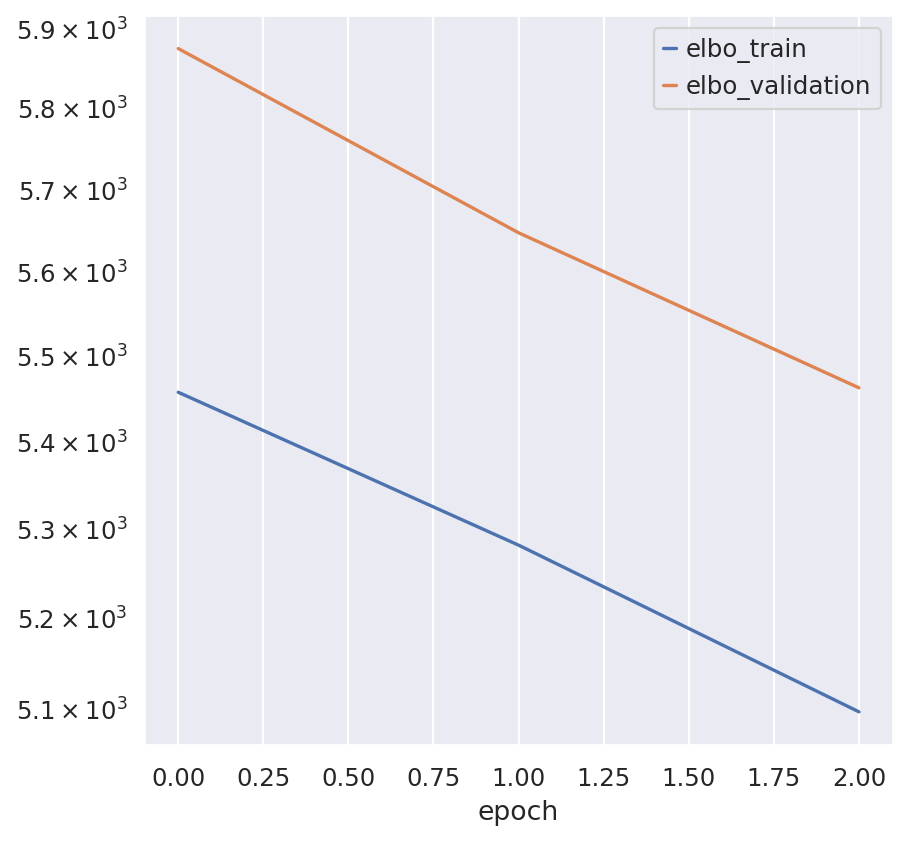

In [11]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[:].plot(logy=True)  # exclude first 10 epochs
plt.show()

### Get the latent space and compute UMAP

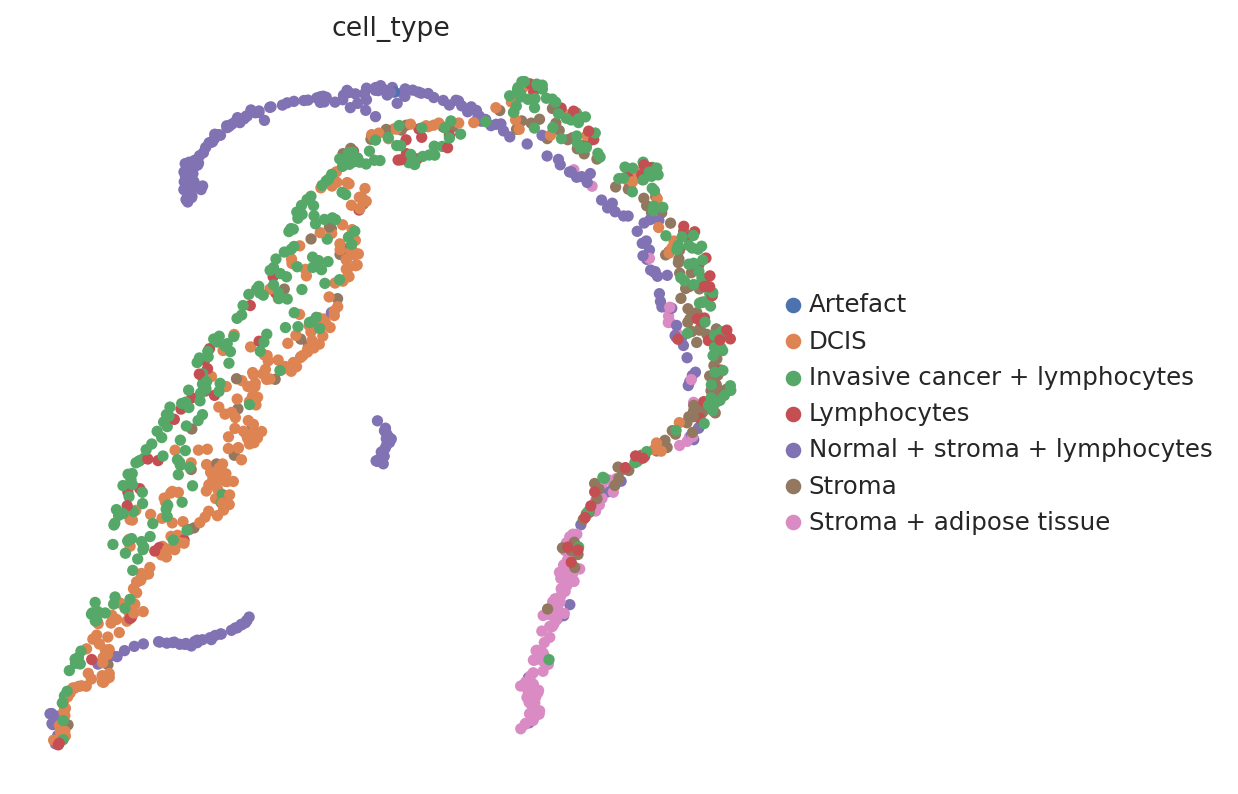

In [12]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")
# sc.pp.pca(adata)
# sc.pl.pca(adata, color="CN")

In [13]:
from sklearn.metrics import silhouette_score

# latent_embeddings are the low-dimensional embeddings for each cell
silhouette_avg_orig = silhouette_score(adata.X, adata.obs['cell_type'])
silhouette_avg_latent = silhouette_score(latent, adata.obs['cell_type'])
print(f"Original silhouette score: {silhouette_avg_orig}")
print(f"Latent silhouette score: {silhouette_avg_latent}")

Original silhouette score: -0.1390186357050346
Latent silhouette score: -0.24525588750839233


## Performing Differential Expression in scVI

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
1. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [14]:
# let's take a look at abundances of different cell types
adata.obs["cell_type"].value_counts()

cell_type
Invasive cancer + lymphocytes    317
DCIS                             273
Normal + stroma + lymphocytes    240
Stroma                           134
Stroma + adipose tissue          114
Lymphocytes                       81
Artefact                           1
Name: count, dtype: int64

scVI provides several options to identify the two populations of interest.

In [15]:
cell_type_1 = "DCIS"
cell_idx1 = adata.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Stroma"
cell_idx2 = adata.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

273 cells of type DCIS
134 cells of type Stroma


### Basic principle

#### DE and log fold-changes

scVI can natively be used to perform differential expression analyses to compare populations of cells, as described [here](https://doi.org/10.1101/794289) and [there](https://doi.org/10.1101/2022.05.27.493625).
It achieves this by estimating the posterior distribution of the log fold-change (LFC) between subpopulations $A$ and $B$.
Specifically, for a given gene g, scVI calculates the LFC as the difference between the logarithm of its expression level in population A, denoted by $h_g^A$, and the logarithm of its expression level in population B, denoted by $h_g^B$.

The resulting value, denoted by $\beta_g$, provides insights into the expression patterns of gene $g$.
Values close to zero indicate that the gene is expressed similarly in both populations, positive values suggest upregulation in population A and negative values indicate downregulation in population A. This information can be used to better understand the biological mechanisms underlying the differences between the two cell populations.

#### DE testing

In addition to estimating the LFC, scVI can also detect which genes have *significant* expression patterns.
To tag which genes are differentially expressed, scVI tests the following competing hypotheses
$M_{1, g}: \beta_g \in [-\delta, \delta]$ and $M_{2, g}: \beta_g \in (-\infty, -\delta) \cup (\delta, \infty)$.
Here, $\delta$ denotes a small LFC threshold, such that $\beta_g \in [-\delta, \delta]$ is evidence that the gene is equally expressed in the two subpopulations.

Differentially expressed genes are identified by computing the posterior probability of $M_{2, g}$.

### Running DE analyses

#### Running and understanding a DE run

A simple DE analysis can then be performed using the following command

In [16]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
7835,0.9392,0.0608,2.737439,0.000044,0.000117,...,0.501832,0.246269,1.502656,1.725731,False
15895,0.9354,0.0646,2.672760,0.000063,0.000152,...,0.267399,0.149254,0.704383,1.224175,False
7468,0.9340,0.0660,2.649822,0.000051,0.000130,...,0.523810,0.201493,1.592923,1.176482,False
6450,0.9336,0.0664,2.643351,0.001696,0.000690,...,0.567766,0.485075,2.122394,6.199764,False
6633,0.9284,0.0716,2.562367,0.001438,0.000600,...,0.967033,0.679104,13.728359,10.507506,False
...,...,...,...,...,...,...,...,...,...,...,...
3231,0.1934,0.8066,-1.428067,0.000279,0.000276,...,0.567766,0.455224,1.807765,4.072653,False
2715,0.1924,0.8076,-1.434490,0.000264,0.000256,...,0.630037,0.350746,2.148081,2.791569,False
418,0.1908,0.8092,-1.444820,0.000260,0.000261,...,0.633700,0.402985,2.174855,2.954749,False
6222,0.1656,0.8344,-1.617138,0.000302,0.000298,...,0.556777,0.253731,1.676222,1.939769,False


This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

#### Main hyperparameters

Additional parameters can be tuned in specific applications.

1. **weights**, which can correspond to <span style="color:#eb5e34">"uniform"</span> or <span style="color:#eb5e34">"importance"</span> specify how normalized gene expressions in the two subpopulations are computed. The <span style="color:#eb5e34">"importance"</span> flavor is specifically designed to provide FDR-calibrated gene sets, but may be overkill if you only aim to rank genes (via their LFC for instance).
1. **filter_outlier_cells** filters out outlier cells prior to computing normalized gene expressions. It is important to set this parameter to `True` when `weights='importance'`.
1. **delta** allows to specify $\delta$, which is used to detect differentially expressed genes. It can also be set automatically using `delta=None`
1. **pseudocounts**, which is zero by default, but can be set to a small value (e.g., 1e-6) when many detected DE genes are seldom expressed in the compared populations.
1. **batch_correction**, which should be set to `True` to account for batch effects. This only makes sense when `idx1` and `idx2` denote cells coming from overlapping batches.

The exact function of these parameters is described [here](https://doi.org/10.1101/2022.05.27.493625).

### Volcano plot of change mode DE with p-values

In [17]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,...,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
7835,0.9442,0.0558,2.828564,0.000045,0.000118,...,0.699138,0.683495,1,0.2246,14576.0
7468,0.9356,0.0644,2.676074,0.000052,0.000131,...,0.733621,0.702555,1,0.2239,14540.0
8674,0.9326,0.0674,2.627331,0.000052,0.000129,...,0.693103,0.662499,1,0.2360,15281.0
15895,0.9308,0.0692,2.599043,0.000064,0.000154,...,0.723276,0.695618,1,0.2215,14402.0
6450,0.9304,0.0696,2.592850,0.001662,0.000673,...,0.340517,0.181094,1,0.2791,18020.0


In [18]:
import torch
torch.cuda.empty_cache()

de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-602.919412688918101 > -616.757172379735266). You may want to try with a higher value of support_fraction (current value: 0.593).
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-598.852905148885043 > -615.125527976754938). You may want to try with a higher value of support_fraction (current value: 0.593).
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-598.745605488661795 > -606.863741096514900). You may want to try with a higher value of support_fraction (

DE...:   0%|          | 0/1 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 186.69 MiB is free. Including non-PyTorch memory, this process has 3.62 GiB memory in use. Of the allocated memory 3.49 GiB is allocated by PyTorch, and 62.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
de_comp.loc[lambda x: x["gene_name"].str.contains("rpl-"), "gene_type"] = "RPL"
de_comp.loc[lambda x: x["gene_name"].str.contains("ceh-"), "gene_type"] = "CEH"
de_comp.loc[lambda x: x["gene_name"].str.contains("flp-"), "gene_type"] = "FPL"

(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)

KeyError: 'gene_name'

Contrary to the `uniform` flavor, the `importance` flavor returns sharper posterior probability scores (posterior probability near 0 or 1, respectively in case of equal expression or differential expression).

### Heatmap of top expressed genes

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

In [18]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/37 [00:00<?, ?it/s]

We focus on cell-types with at least 500 cells, and which have annotations to facilitate heatmap visualization

In [19]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [20]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)["index"]
    .unique()
)

/tmp/ipykernel_154/3695070939.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


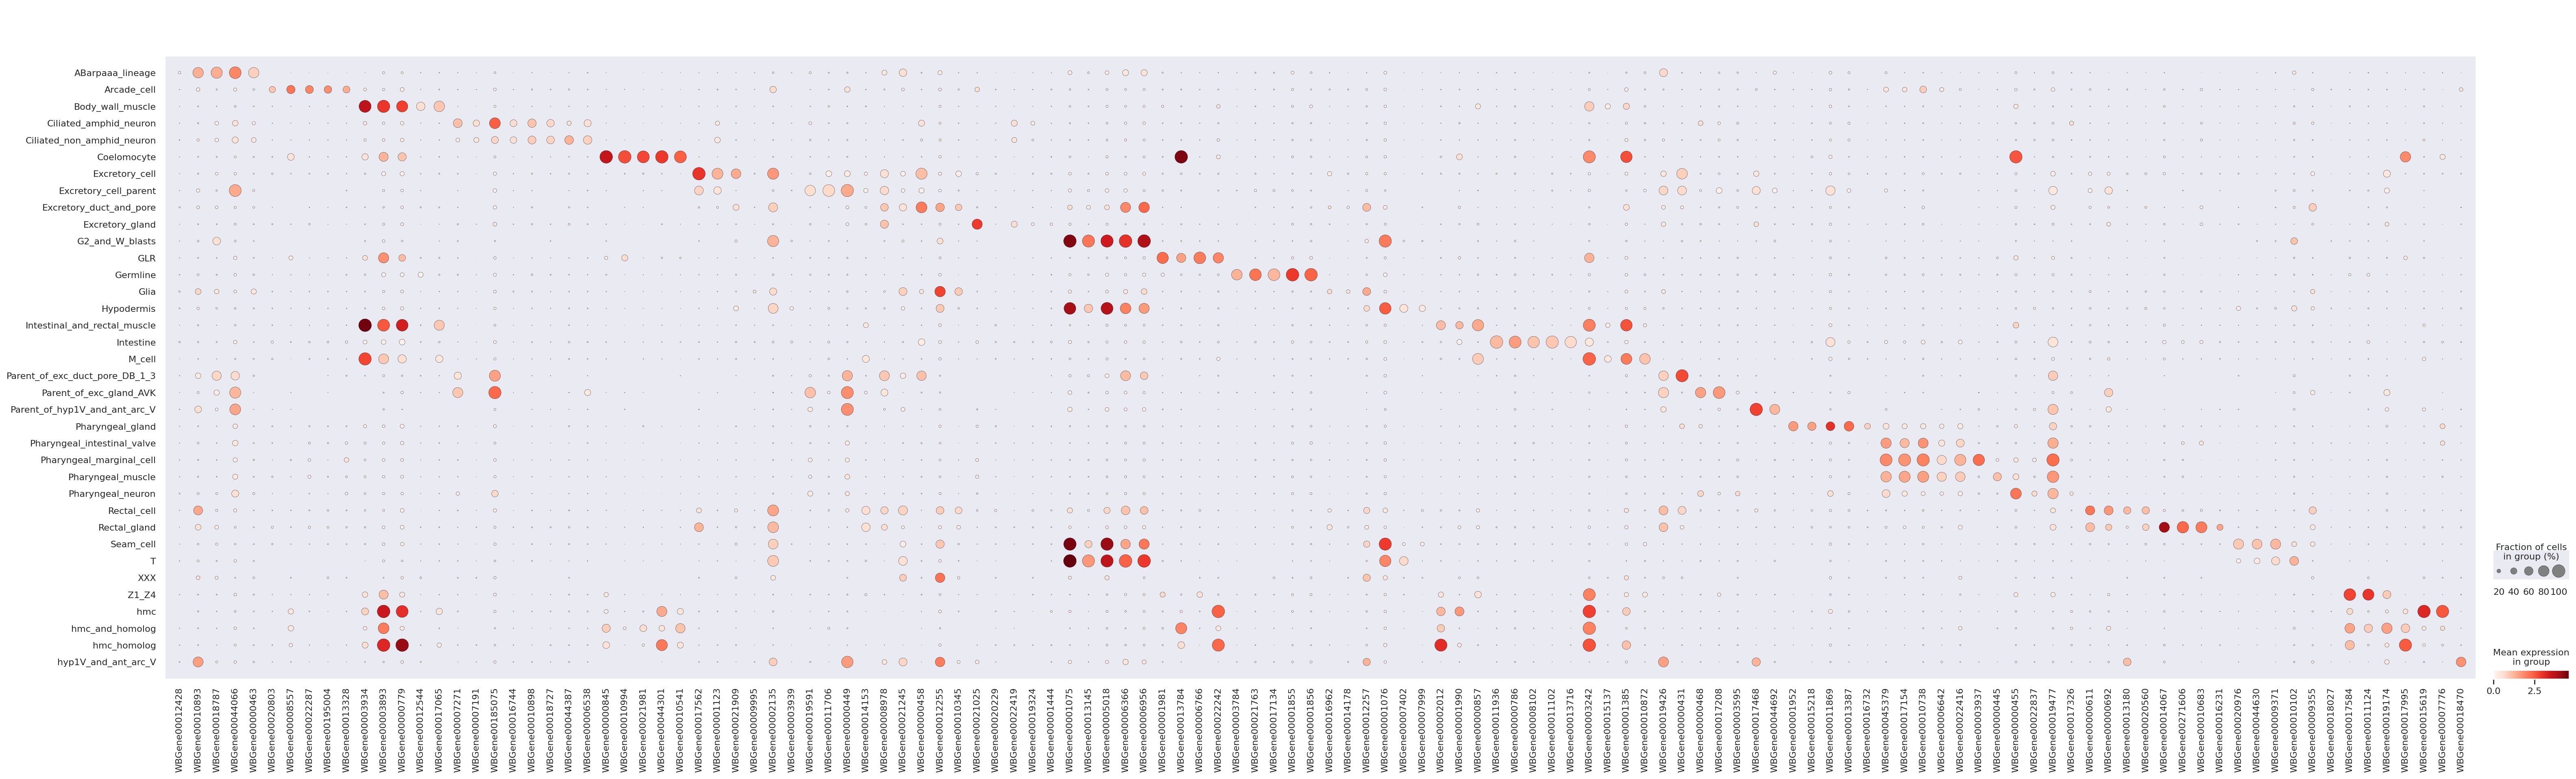

In [21]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(adata_log, marker_genes, groupby="cell_type")